<a href="https://colab.research.google.com/github/jpastolfo/Seismic-Velocity-Model-Inversion/blob/main/Treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pré-processamento

In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt


In [3]:
shot_size = (640,128) #tamanho dos tiros
img_size = (128,128) #tamanho das imagens
n_filters = 12 #número de tiros

In [4]:
# Chamando os arquivos dos seus diretórios

data_dir ='/content/drive/MyDrive/sismico/Shots1/'
mod_dir = '/content/drive/MyDrive/sismico/Modelo1/Bin/'
# LOADING PATHS
shot_list = [xn for xn in os.listdir(data_dir) if "shot" in xn]
mask_list = [xn for xn in os.listdir(mod_dir) if "mod" in xn]
mask_list.sort()
shot_list.sort()

# LOADING IMAGES

x_data = np.zeros( (len(shot_list), )+img_size+(n_filters, ) )
y_data = np.zeros( (len(shot_list), )+img_size)
for i in range(len(shot_list)):
    ent=np.load(data_dir + shot_list[i])
    sai=np.load(mod_dir + mask_list[i])
#    ent.shape
    x_data[i,:,:,:] = np.transpose(ent[ :,:,0:640:5],(2,1,0)) # transposição devido a forma de escrita do deepwave # escolha de subamostrar os tiros a cada 5 amostras
    y_data[i,:,:] = sai[:,:]

In [5]:
# normalizando x_data e y_data

def normalize_function(img):
    imag = img
    vis_p_max = np.percentile(imag, 96)
    vis_p_min = -np.percentile(imag, 96)
    clip=(vis_p_max - vis_p_min)/2
    imag = np.clip(imag,-clip,clip)
    imag=(imag+clip)/(2*clip)
    return imag

for filt in range(n_filters):
    x_data[:, :, :, filt] = normalize_function(x_data[:, :, :, filt])
y_data=y_data/1000 # trata a velocidade como km/s, range de saída menor
y_data=(y_data-1.5)/2.0

In [6]:
print('x_data (Shots): {} \ny_data (Modelos): {}'.format(x_data.shape, y_data.shape))

x_data (Shots): (300, 128, 128, 12) 
y_data (Modelos): (300, 128, 128)


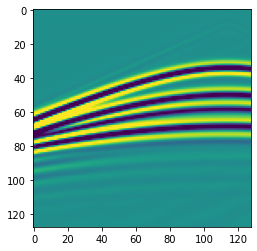

In [7]:
plt.imshow(x_data[200, :, :, 11])

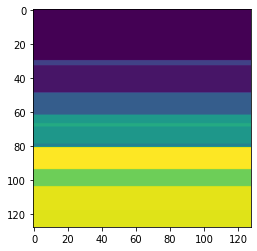

In [8]:
plt.imshow(y_data[200, :, :])

In [9]:
!ls /content/drive/MyDrive/notebook/*py
import sys
sys.path.append('/content/drive/MyDrive/notebook/')

/content/drive/MyDrive/notebook/modelos.py


In [10]:
from modelos import get_unet, get_unet_mod, ssim_loss, ssim_loss_rsme, Input, Adam, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, tf

In [11]:
input_img = Input((128, 128, n_filters), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, moment=0.2 ,batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0002), loss=tf.keras.losses.MeanSquaredError(), metrics=["mean_absolute_error"]) #zera os pesos

In [12]:
#divisão de conjuntos de teste treino e validação e parâmetros gerais da rede
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

img_train, x_test, mask_train, y_test = train_test_split(x_data, np.expand_dims(y_data, axis=-1), 
                                                    test_size=0.02, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(img_train, np.expand_dims(mask_train, axis=-1), 
                                                    test_size=1/8, random_state=42)
BATCH = 8
EPOCAS = 100

loss = np.zeros((EPOCAS))
val_loss =np.zeros((EPOCAS))
accuracy =np.zeros((EPOCAS))
val_accuracy = np.zeros((EPOCAS))
ims= []

In [13]:
## Call Backs
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model_teste01.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(x_train, y_train, batch_size=BATCH, epochs=EPOCAS, callbacks=callbacks, validation_data=(x_val, y_val))

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.5217 - mean_absolute_error: 0.5449
Epoch 1: val_loss improved from inf to 0.17876, saving model to model_teste01.h5
33/33 [==============================] - 23s 346ms/step - loss: 0.5217 - mean_absolute_error: 0.5449 - val_loss: 0.1788 - val_mean_absolute_error: 0.3419
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.2641 - mean_absolute_error: 0.3860
Epoch 2: val_loss did not improve from 0.17876
33/33 [==============================] - 6s 179ms/step - loss: 0.2639 - mean_absolute_error: 0.3858 - val_loss: 0.2172 - val_mean_absolute_error: 0.3265
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.1709 - mean_absolute_error: 0.3095
Epoch 3: val_loss improved from 0.17876 to 0.15497, saving model to model_teste01.h5
33/33 [==============================] - 7s 208ms/step - loss: 0.1707 - mean_absolute_error: 0.3093 - val_loss: 0.1550 - val_mean_absolute_error: 0.2734
Epoch 4/1

In [15]:
import pandas as pd
hist_df = pd.DataFrame(results.history) 

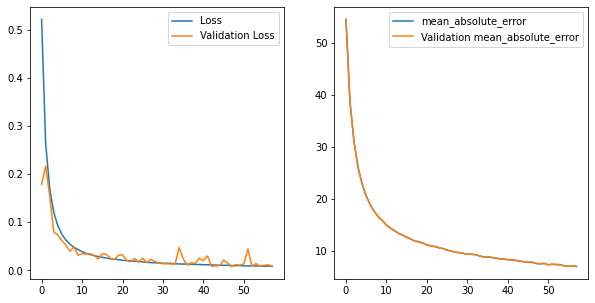

In [16]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(results.history['loss'], '-', label = 'Loss')
ax1.plot(results.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(results.history['mean_absolute_error']), '-', 
         label = 'mean_absolute_error')
ax2.plot(100*np.array(results.history['mean_absolute_error']), '-',
         label = 'Validation mean_absolute_error')
ax2.legend()

In [25]:
#Nesse ponto, usaremos dados novos para fazer o teste na rede!!
preds = model.predict(x_data)

10/10 [==============================] - 1s 86ms/step


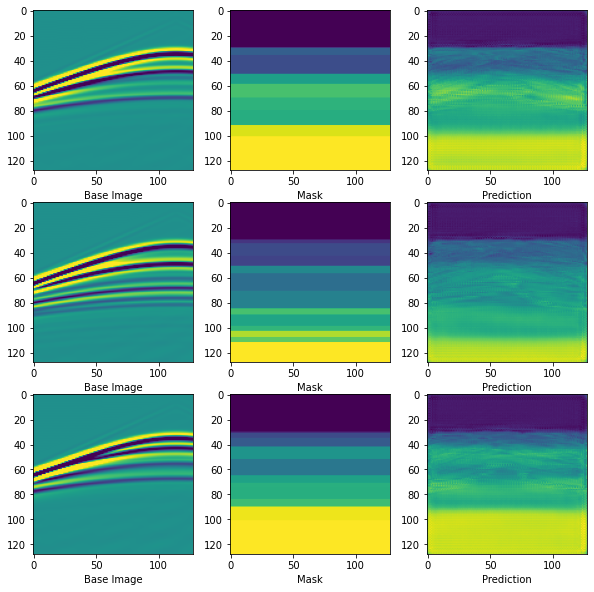

In [47]:
plt.figure(figsize=(10,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(x_data[i, :, :, 11])
    plt.xlabel("Base Image")
    
    plt.subplot(3,3,i+2)
    plt.imshow(y_data[i, :, :])
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[i, :, :]))
    plt.xlabel("Prediction")

In [73]:
# Utilizando o índice de jaccard para verificar se nossos dados oriundos do predict
# são similares com o gabarito

from sklearn.metrics import jaccard_score

jaccard_score(y_data, np.squeeze(preds), average='micro')

ValueError: ignored

In [72]:
np.squeeze(preds).shape 

(300, 128, 128)

In [70]:
y_data.shape

(300, 128, 128)